In [1]:
import math

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('future.no_silent_downcasting', True)

def gnanc(df):
    """[G]et [NaN] [C]olumns"""
    columns = df.columns
    return DF({
        'column': columns,
        'hasNaN': [df[c].isnull().any() for c in columns],
        'NaNs': [df[c].isnull().sum() for c in columns]
    })

# Questão 2

> Esta questão aborda a aplicação prática de um problema de Ciência de Dados utilizando Machine Learning. O objetivo é prever se os indivíduos irão cancelar suas reservas em uma rede de hotéis, utilizando o conjunto de dados Hotel Booking Demand. Siga os passos abaixo para desenvolver sua solução.

## Análise Descritiva dos Dados

Carregando dados:

In [2]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "hotel_bookings.csv"

# Load the latest version
q2_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "jessemostipak/hotel-booking-demand",
  file_path,
)

q2_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.000,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.000,NaN,0,Transient,98.000,0,1,Check-Out,2015-07-03


Separando partes:

In [3]:
X = q2_df.drop('is_canceled', axis=1)
y = q2_df[['is_canceled']]

### Sumários:

In [4]:
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
q2_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.000,0.370,0.483,0.000,0.000,0.000,1.000,1.000
lead_time,119390.000,104.011,106.863,0.000,18.000,69.000,160.000,737.000
arrival_date_year,119390.000,2016.157,0.707,2015.000,2016.000,2016.000,2017.000,2017.000
arrival_date_week_number,119390.000,27.165,13.605,1.000,16.000,28.000,38.000,53.000
arrival_date_day_of_month,119390.000,15.798,8.781,1.000,8.000,16.000,23.000,31.000
stays_in_weekend_nights,119390.000,0.928,0.999,0.000,0.000,1.000,2.000,19.000
stays_in_week_nights,119390.000,2.500,1.908,0.000,1.000,2.000,3.000,50.000
adults,119390.000,1.856,0.579,0.000,2.000,2.000,2.000,55.000
children,119386.000,0.104,0.399,0.000,0.000,0.000,0.000,10.000
babies,119390.000,0.008,0.097,0.000,0.000,0.000,0.000,10.000


### Colunas com null/NaN:

In [6]:
nan_df = gnanc(q2_df)
nan_df[nan_df['hasNaN']]

,column,hasNaN,NaNs
10,children,True,4
13,country,True,488
23,agent,True,16340
24,company,True,112593


### Total de registros:

In [7]:
len(q2_df)

119390

(A maior parte dos registros não têm empresa.)

### Variáveis categóricas

In [8]:
buckets = [
    'hotel', 'meal', 'market_segment', 'distribution_channel',
    'deposit_type', 'customer_type', 'reservation_status',
    'reserved_room_type', 'assigned_room_type',
    'country', 'company', 'agent'
]

buckets_df = DF({
    'dtype': [q2_df[b].dtype for b in buckets],
    'count': [q2_df[b].unique().size for b in buckets]
}, index=buckets)
buckets_df

,dtype,count
hotel,object,2
meal,object,5
market_segment,object,8
distribution_channel,object,5
deposit_type,object,3
customer_type,object,4
reservation_status,object,3
reserved_room_type,object,10
assigned_room_type,object,12
country,object,178


Algumas categorias são muito grandes, vamos restringir:

In [9]:
categories_df = buckets_df[buckets_df['count'] <= 12]

`children` deve ser inteiro. Único empecilho são meros 4 linhas com valor `nan` para children, quase certamente erros. Vamos converter para zero:

In [10]:
X['children'] = X['children'].fillna(0).astype(int, copy=False)

### Gráficos

#### Cancelamentos e não cancelamentos:

<Axes: xlabel='is_canceled', ylabel='count'>

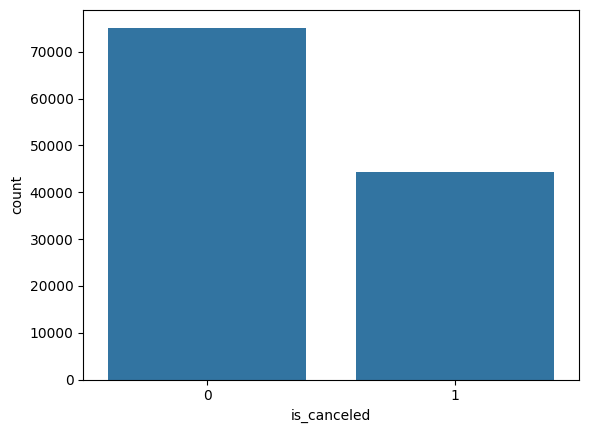

In [11]:
sns.countplot(data=q2_df, x="is_canceled")

Há uma diferença significativa, mas não parece tão impactante. Não vamos balancear a base.

#### Variáveis categóricas:

In [12]:
def countplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.countplot(data=df, x=col, ax=ax, hue="is_canceled")
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

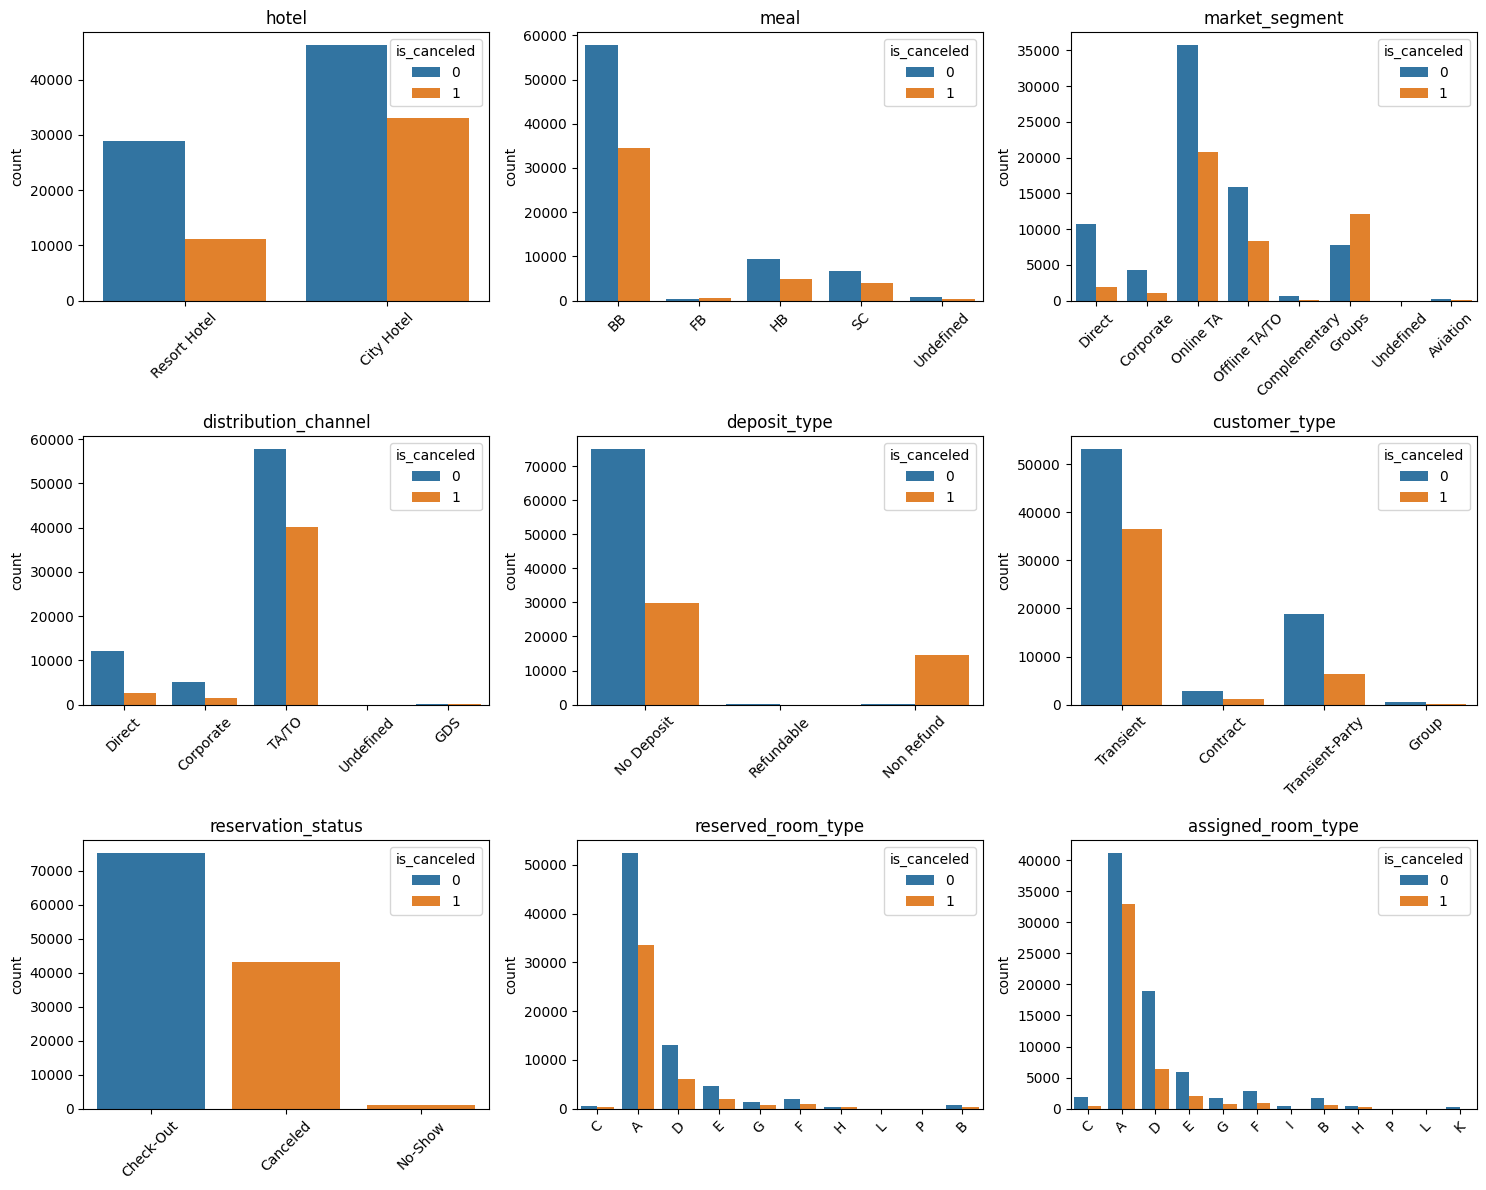

In [13]:
countplots(q2_df, categories_df.index)

`reservation_status` tem basicamente a mesma informação de `is_canceled`, e assim como `is_canceled`, só temos essa informação tarde demais, então vamos removê-lo.

In [14]:
def drop(df, *columns):
    df.drop(list(columns), axis=1, inplace=True)

drop(X, 'reservation_status', 'reservation_status_date')

categories_df= categories_df.drop(index='reservation_status')

#### Boxplot de variáveis numéricas

In [15]:
def boxplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.boxplot(data=df, y=col, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

numeric = [
    'lead_time',  'adults', 'children', 'babies', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'required_car_parking_spaces',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr','total_of_special_requests'
]

numbers_df = DF({
    'dtype': [q2_df[b].dtype for b in numeric],
    'count': [q2_df[b].unique().size for b in numeric]
}, index=numeric)
numbers_df

,dtype,count
lead_time,int64,479
adults,int64,14
children,float64,6
babies,int64,5
stays_in_weekend_nights,int64,17
stays_in_week_nights,int64,35
required_car_parking_spaces,int64,5
previous_cancellations,int64,15
previous_bookings_not_canceled,int64,73
booking_changes,int64,21


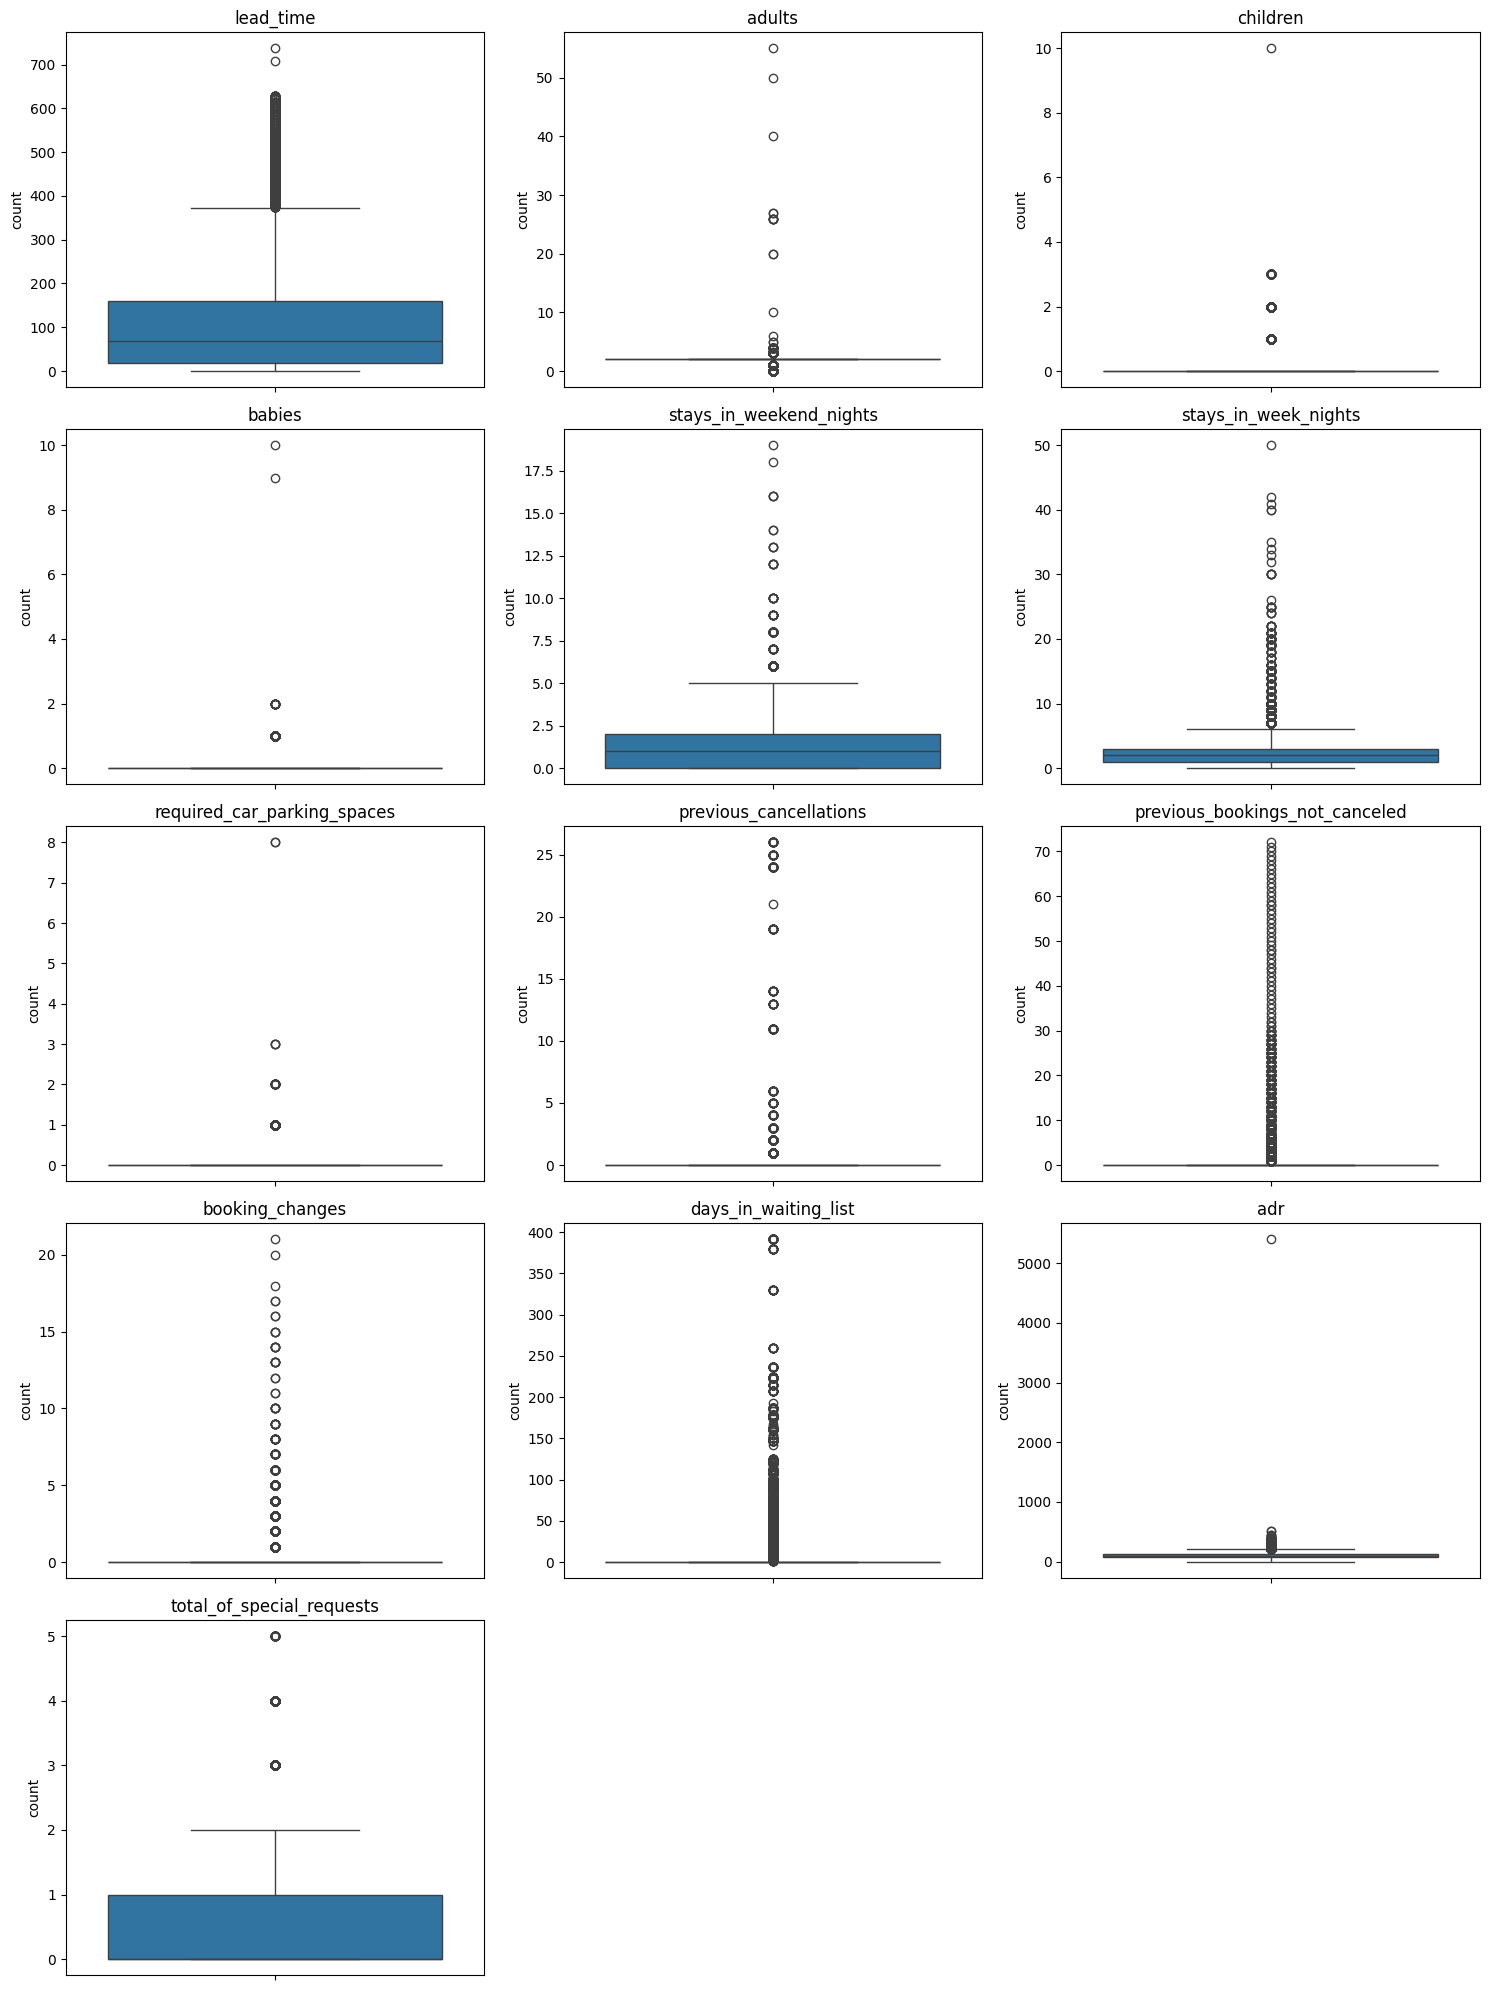

In [16]:
boxplots(q2_df, numbers_df.index)

ADR (que é aproximadamente gasto por noite) tem um outlier absurdo:

In [17]:
q2_df.sort_values(by='adr', ascending=False).head()[['hotel', 'is_canceled', 'adr']]

,hotel,is_canceled,adr
48515,City Hotel,1,5400.000
111403,City Hotel,0,510.000
15083,Resort Hotel,0,508.000
103912,City Hotel,0,451.500
13142,Resort Hotel,1,450.000


Este valor é tão desproporcional e único, que vamos removê-lo da base.

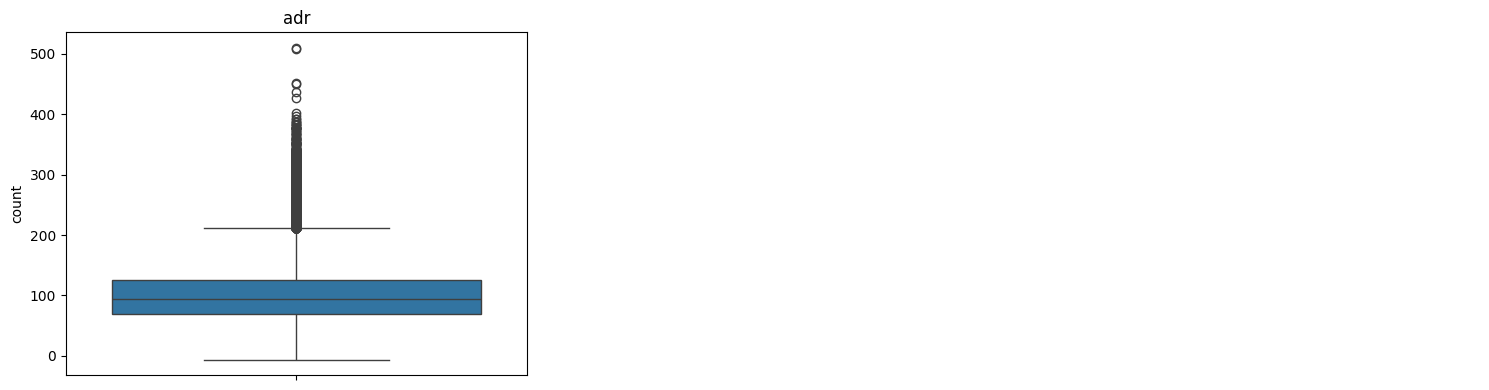

In [18]:
outlier = X[X['adr'] > 2000].index
X = X.drop(outlier)
y = y.drop(outlier)
boxplots(X, ['adr'])

Todos são muito _skewed_. Poderíamos balancear a base, mas dada a quantidade de conlunas com muita variação, vamos remover as menos relevantes, e usar métodos com regularização mais tarde.

Vejamos uns histogramas:

In [19]:
def histograms(df, columns, per_row=3, bins=5, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.histplot(data=df, x=col, ax=ax, bins=bins)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

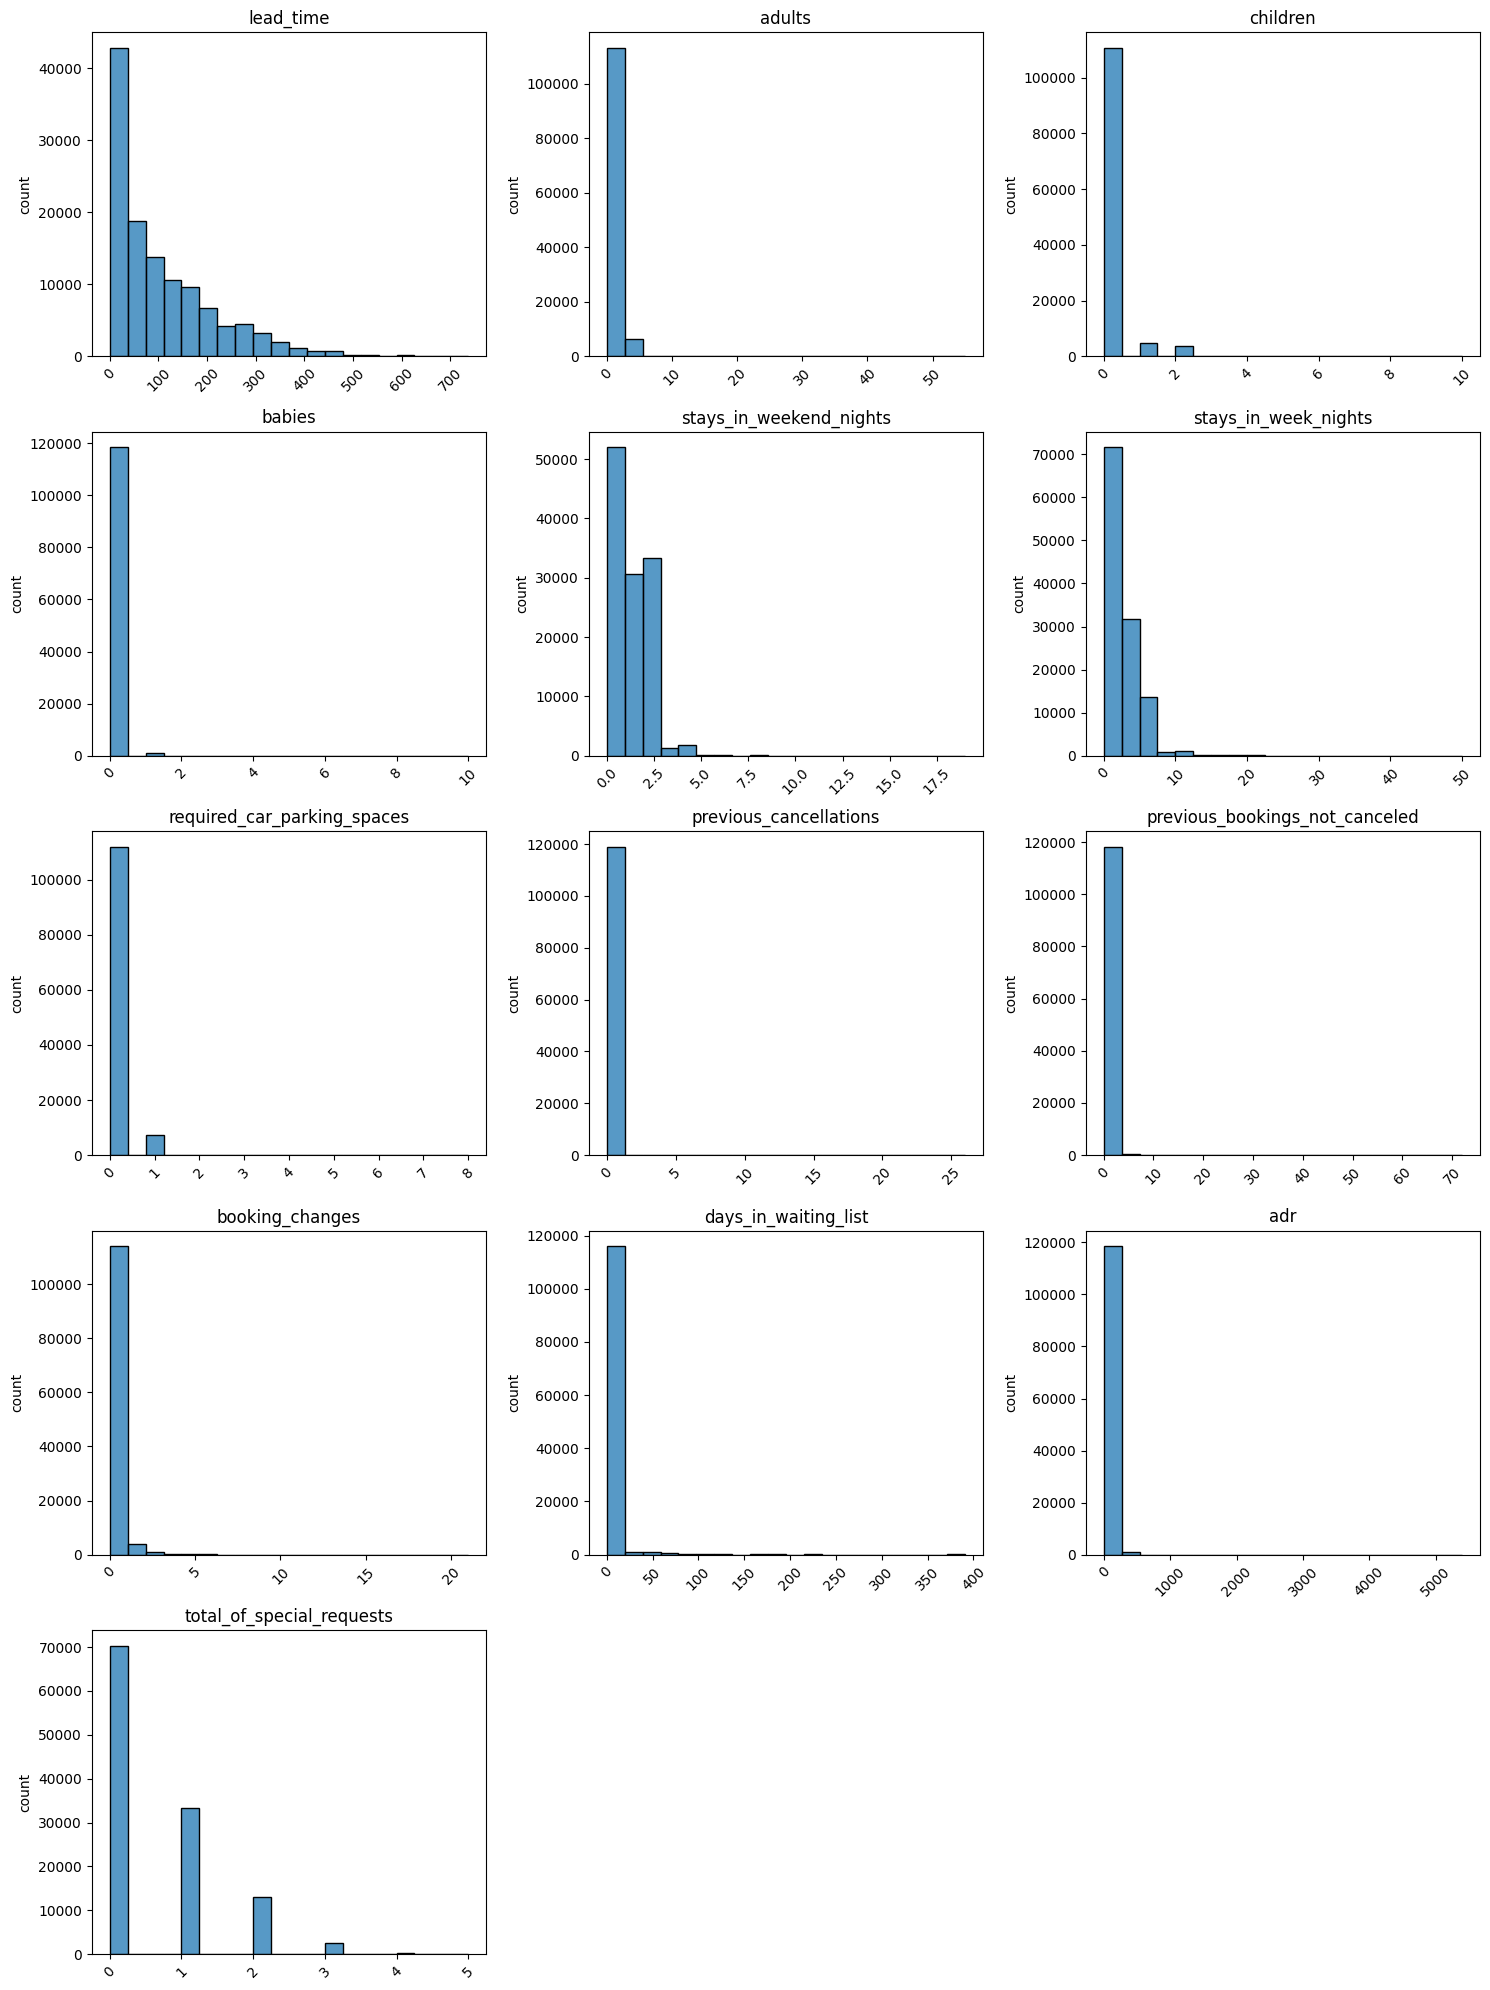

In [20]:
histograms(q2_df, numbers_df.index, bins=20)

Difícil availar o número de bookings não cancelados e dias de espera. Façamos um gráfico de proporções

In [21]:
def count_canceled(df, factor, output):
    counting = DF(df[factor].value_counts())
    counting['canceled'] = [
        sum(df[output][df[factor] == c]) for c in counting.index
    ]
    counting["not_canceled"] = counting.iloc[:, 0] - counting["canceled"]
    counting["canceled%"] = counting["canceled"] / counting.iloc[:, 0]
    counting["not_canceled%"] = counting["not_canceled"] / counting.iloc[:, 0]
    counting.sort_index(inplace=True)
    return counting

def binned_counting(counting, factor_name, num_bins):
    bins = np.linspace(
        counting.index.min(),
        counting.index.max(),
        num_bins + 1
    )

    counting = counting.copy()
    counting['bin'] = pd.cut(counting.index, bins, include_lowest=True)
    #return counting
    groups = counting.groupby('bin', observed=True)
    groups_medians = groups['bin'].first().apply(lambda x: x.mid).astype(float)
    exited_count = groups['canceled'].sum()
    #return exited_count
    stayed_count = groups['not_canceled'].sum()
    total_count = exited_count + stayed_count

    counting = pd.DataFrame({
        'count': total_count,
        factor_name: groups_medians,
        'canceldd': exited_count,
        'not_canceled': stayed_count,
        'canceled%': exited_count / total_count,
        'not_canceled%': stayed_count / total_count,
    }, index=groups_medians)
    return counting

def proportions(df, columns, proportional=True, per_row=3, width=5, height=4):  
    suffix = '%' if proportional else ''

    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        counting = count_canceled(df, col, 'is_canceled')
        sns.set(style="whitegrid")
    
        x = counting.index
        yes = counting["canceled%"]
        no = counting["not_canceled%"]

        
        ax.stackplot(x, yes, no, labels=["canceled", "not_canceled"])
        
        ax.legend(loc="upper right")
        ax.set_xlabel("Index")
        ax.set_ylabel("Proportion")
        ax.set_title(f"Proporção de cancelamento por {col}")
    plt.show()
    

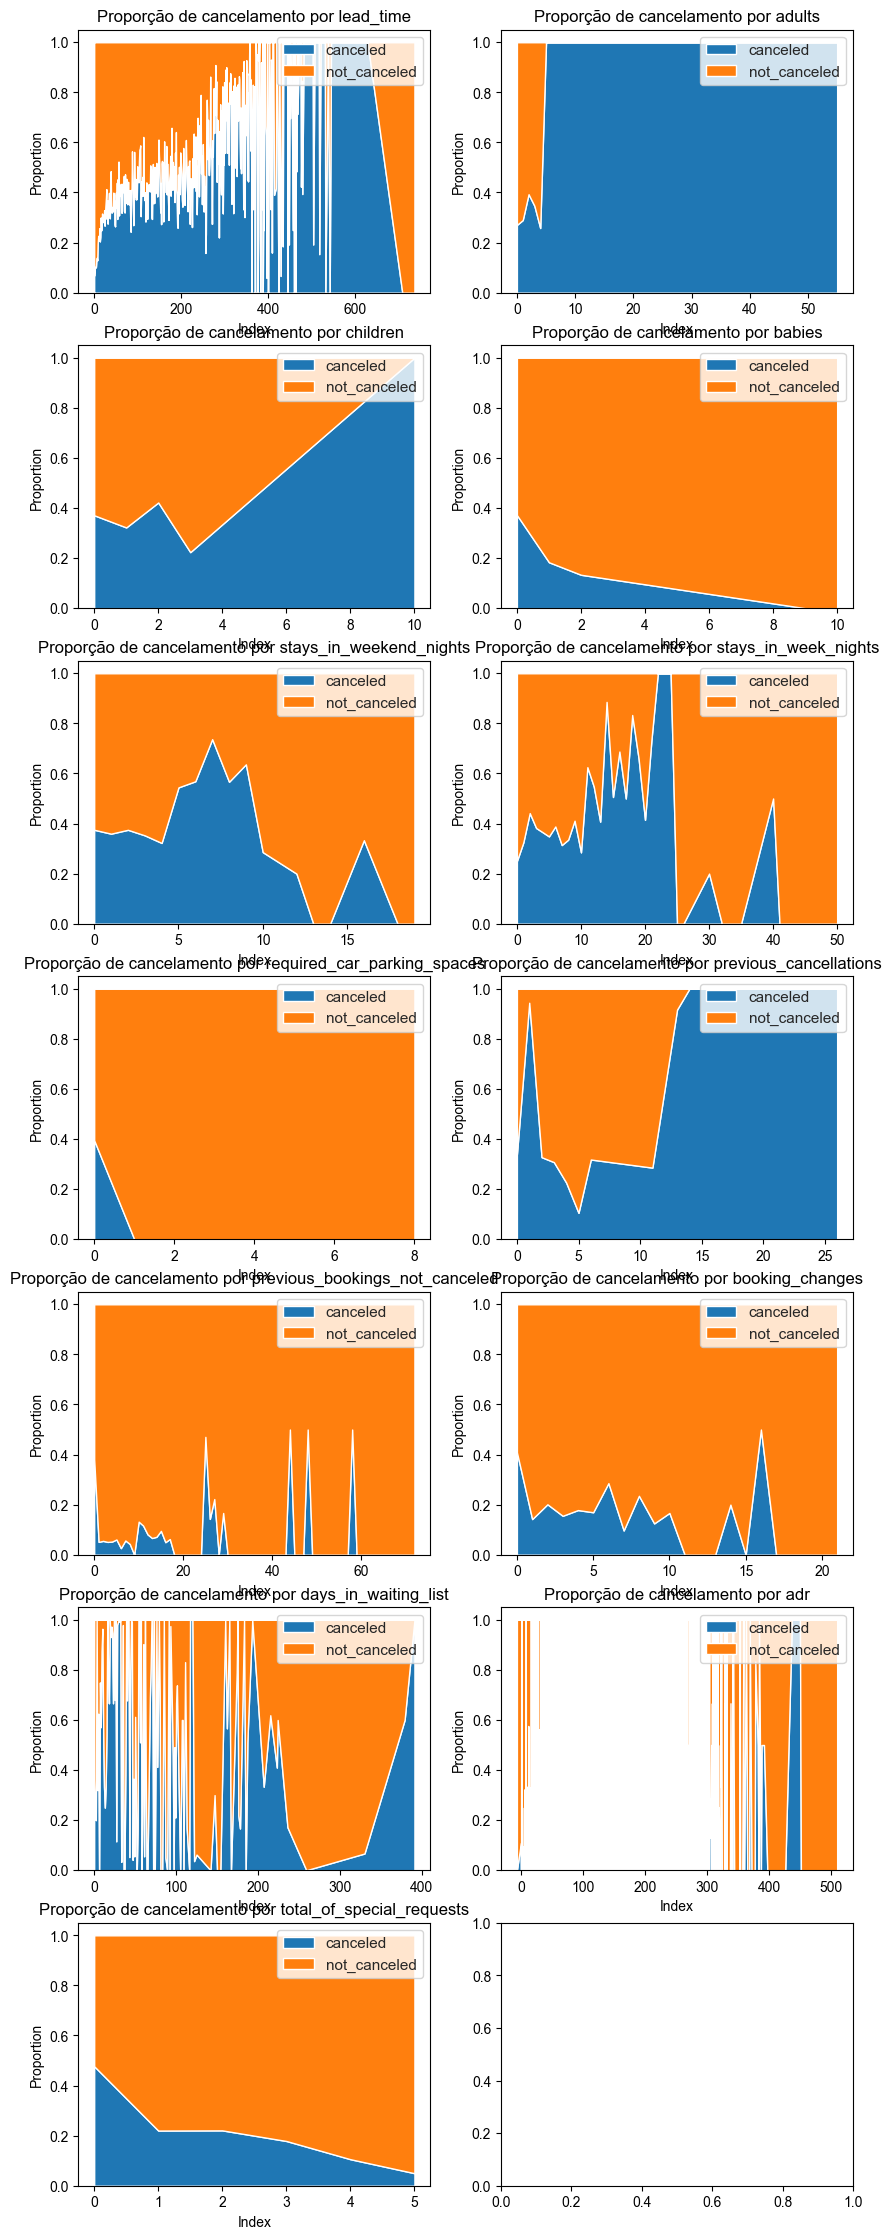

In [22]:
proportions(pd.concat([X, y], axis=1), numbers_df.index, per_row=2)

Os gráficos são horríveis, mas o importante é que mostram que são valors relevantes, nenhum deles é vazio de informação.

#### Coluna `country`

Esses são valores categóricos que possuem categorias demais:

In [23]:
print(q2_df['country'].unique().size)
print(q2_df['company'].unique().size)
print(q2_df['agent'].unique().size)

178
353
334


`country` podem ser agrupados. Podemos usar os agrupamentos do World Bank [[ourworldindata.org]]()b

In [24]:
def normalize_country(series):
    # This map I've got from ChatGPT
    parent_map = {
        'CN': 'CHN',    # Correcting China
        'CYM': 'GBR',   # Cayman Islands → United Kingdom
        'HKG': 'CHN',   # Hong Kong → China
        'MAC': 'CHN',   # Macao → China
        'GIB': 'GBR',   # Gibraltar → United Kingdom
        'JEY': 'GBR',   # Jersey → United Kingdom
        'GGY': 'GBR',   # Guernsey → United Kingdom
        'IMN': 'GBR',   # Isle of Man → United Kingdom
        'VGB': 'GBR',   # British Virgin Islands → United Kingdom
        'AIA': 'GBR',   # Anguilla → United Kingdom
        'FRO': 'DNK',   # Faroe Islands → Denmark
        'GLP': 'FRA',   # Guadeloupe → France
        'MYT': 'FRA',   # Mayotte → France
        'PYF': 'FRA',   # French Polynesia → France
        'ATF': 'FRA',   # French Southern Territories → France
        'ABW': 'NLD',   # Aruba → Netherlands
        'ASM': 'USA',   # American Samoa → United States
        'UMI': 'USA',   # U.S. Minor Outlying Islands → United States
        'TMP': 'TLS',   # Old East Timor code → Timor-Leste
        'ATA': 'ATA',   # Antarctica → Antatctica
        'CN': 'CHN',    # Fix invalid code → China
    }
    return series.fillna('NDA').replace(parent_map)

X['country:parent'] = normalize_country(X['country'])

## Getting WB codes
def world_bank_countries_groups():
    df = pd.read_csv(
        'https://ourworldindata.org/grapher/'
        'world-regions-according-to-the-world-bank.csv?'
        'v=1&csvType=filtered&useColumnShortNames=true&'
        'overlay=download-data',
        storage_options = {
            'User-Agent': 'Our World In Data data fetch/1.0'
        }
    )
    
    ## Apparently people book hotels from Antarctica...
    df.loc[len(df)] = ['Antarctica', 'ATA', 2023, 'Antarctica', 2023]
    df.loc[len(df)] = ['No Data Available', 'NDA', 2023, 'No Data Available', 2023]
    
    df.set_index('Code', inplace=True)
    
    ### Create codes for legibility (names are too long)
    df['wb_region:code'] = df['wb_region'].apply(
        lambda s:
            ''.join(
                c for c in s if c.isupper()
            ).replace('WB', '')
    )
    return df

wb_countries_df = world_bank_countries_groups()

X['country:wb_region'] = X['country:parent'].replace(
    wb_countries_df['wb_region:code'].to_dict()
)

# Getting proportion of cancelations per region
X_y = pd.concat([X, y], axis=1)
wb_region_groupby = X_y.groupby('country:wb_region')
wb_regions_canceled_df = DF({
    'canceled': wb_region_groupby['is_canceled'].sum(),
    'total': wb_region_groupby.size()
})

wb_regions_canceled_df['canceled%'] = (
    wb_regions_canceled_df['canceled'] / 
        wb_regions_canceled_df['total']
)

import geopandas as gpd

def get_world_map(wb_countries_df):
    # Data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
    # Item "Admin 0 - Countries"
    world = gpd.read_file("ne_110m_admin_0_countries.shp")
    # For some reason, these countries have different codes.
    world.loc[world['SOVEREIGNT'] == 'Norway', 'ISO_A3'] = 'NOR'
    world.loc[world['SOVEREIGNT'] == 'France', 'ISO_A3'] = 'FRA'

    world = world.merge(
        wb_countries_df,
        left_on="ISO_A3", right_index=True,
        how="left"
    )
    world['wb_region:code'] = world['wb_region:code'].fillna('NDA')
    return world

world = get_world_map(wb_countries_df[['wb_region:code']])
world['canceled'] = world["wb_region:code"].replace(
    wb_regions_canceled_df['canceled%'].to_dict()
)

def plot_world(world):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    world.plot(
        column="canceled",
        cmap="Blues",
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=False,
    )
    
    ax.set_title("Proporção de cancelamentos por região do globo", fontsize=16)
    ax.axis("off")
    
    sm = plt.cm.ScalarMappable(
        cmap="Blues",
        norm=plt.Normalize(
            vmin=world["canceled"].min(),
            vmax=world["canceled"].max()
        )
    )
    sm._A = []  # required by matplotlib
    
    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.046,
        pad=0.04
    )
    cbar.ax.tick_params(labelsize=10)
    cbar.formatter.set_powerlimits((-2, 2))
    
    plt.show()

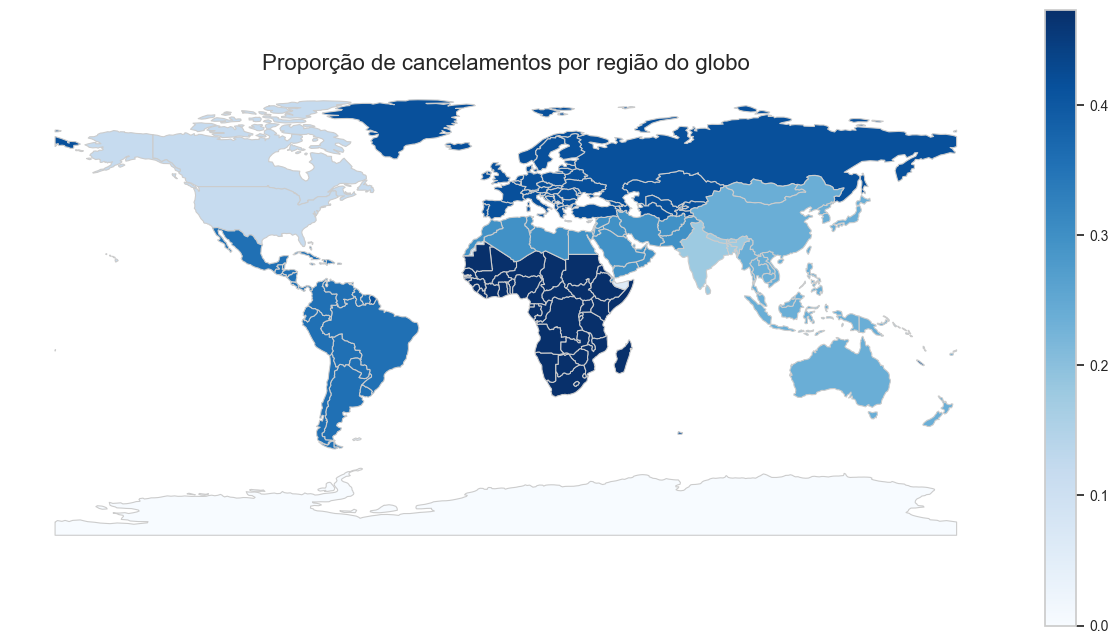

In [25]:
plot_world(world)

VEmos no gráfico que as regiões oferecem informação bem relevante, então vamos mantê-las.

#### Colunas `company`  e `agent`
`company` e `agent` são especialmente problemáticos porque são raramente setados. E possuem muitos valores, não dá para usar one-hot enconding. 



In [26]:
q2_df.groupby('company')['is_canceled'].sum().sort_values()

company
61.000       0
64.000       0
65.000       0
71.000       0
76.000       0
          ... 
153.000     48
348.000     59
40.000      77
223.000    119
67.000     175
Name: is_canceled, Length: 352, dtype: int64

In [27]:
q2_df.groupby('agent')['is_canceled'].sum().sort_values()

agent
535.000        0
527.000        0
510.000        0
508.000        0
54.000         0
           ...  
19.000       780
6.000       1025
1.000       5280
240.000     5484
9.000      13264
Name: is_canceled, Length: 333, dtype: int64

Mas são importantes, e podemos usar target enconding [[scikit-learn.org]](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html). Vamos criar uma pipeline:

In [28]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(
    [
        ('company:mean', TargetEncoder(), ['company']),
        ('agent:mean', TargetEncoder(), ['agent'])
    ],
    remainder='passthrough'
)
pipeline_items = [
    ('transformer', transformer),
]

Também precisamos remover os NaN.

In [29]:
X['company'] = X['company'].fillna(0)
X['agent'] = X['agent'].fillna(0)

#### Data de chegada

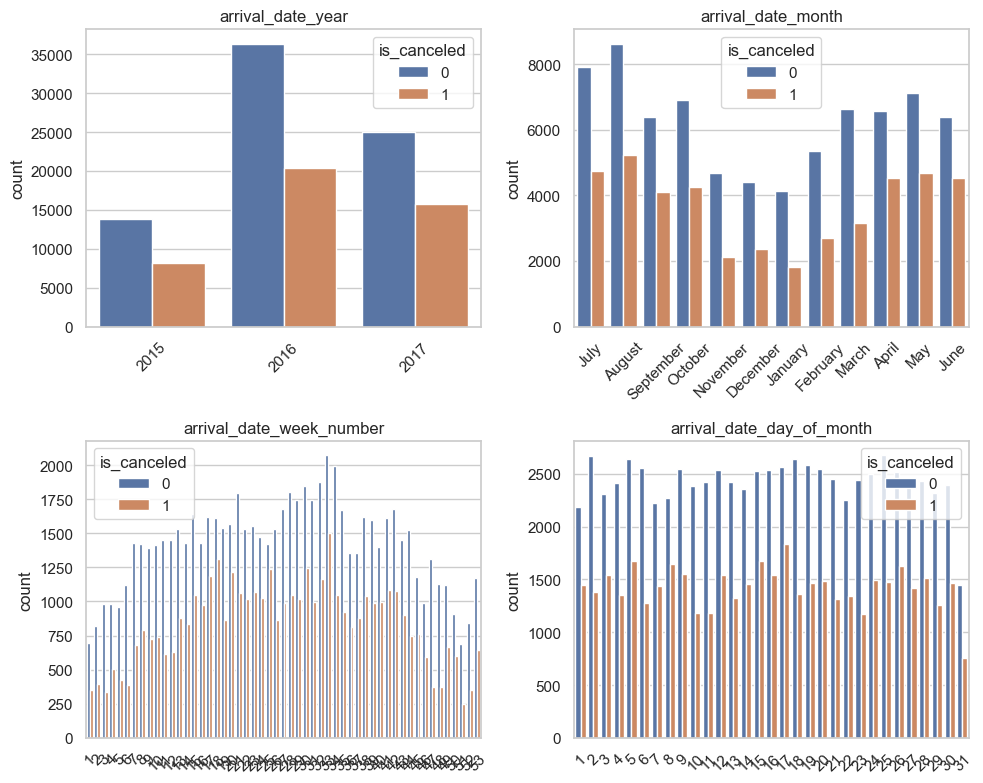

In [30]:
arrival_date_fields = [
    c for c in q2_df.columns
    if c.startswith('arrival_date')
]
countplots(q2_df, arrival_date_fields, per_row=2)

Padrões interessants por dai da semana, mês, ano etc. Talvez o timestamp tenha informaçaõ também, mas **não vamos adicionar o timestamp porque ele já é uma combinaçaõ linear dos outros fatores.**

Precisamos converter mês em um número. Além disso, embora ano tenha um poder de decisão razoável, nós queremos prever eventos futuros, então vamos removê-lo.

In [31]:
import calendar
month_names = list(calendar.month_name)
X['arrival_date_month:number'] = X['arrival_date_month'].map(month_names.index)
X.drop(['arrival_date_month', 'arrival_date_year'], axis=1, inplace=True)

### Correlações
Vamos calcular correlações (aqui faremos um target enconding de `company`, `country` e `agent`):

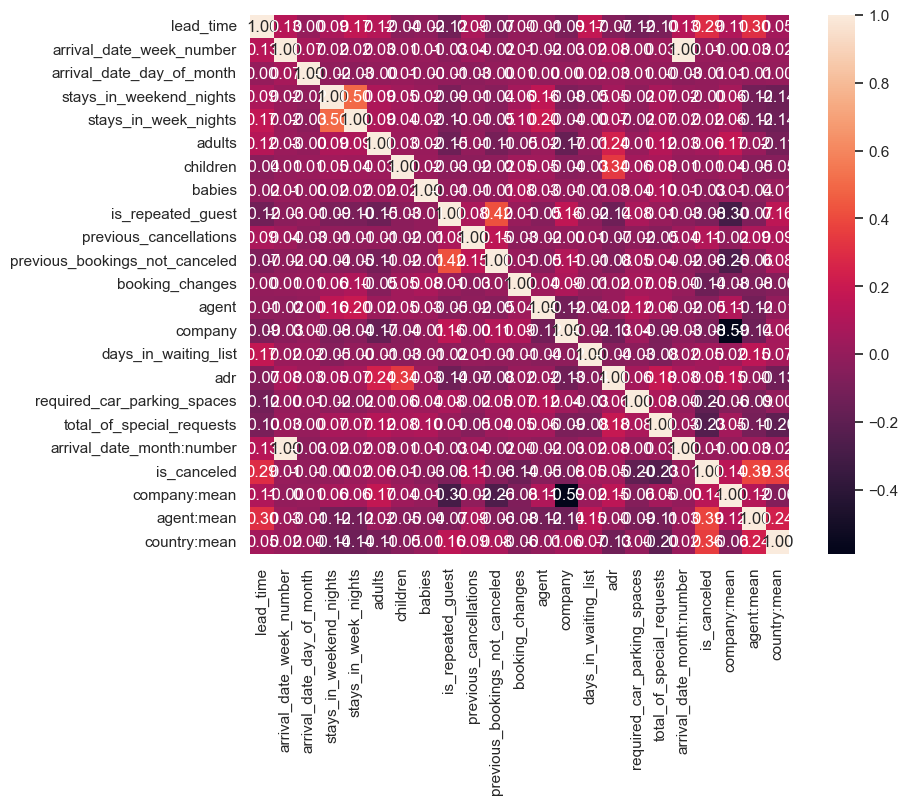

,column1,column2,corr:abs
38,arrival_date_week_number,arrival_date_month:number,0.995
214,company,company:mean,0.588
63,stays_in_weekend_nights,stays_in_week_nights,0.499
149,is_repeated_guest,previous_bookings_not_canceled,0.418
248,is_canceled,agent:mean,0.386
249,is_canceled,country:mean,0.361
125,children,adr,0.341
20,lead_time,agent:mean,0.305
159,is_repeated_guest,company:mean,0.301
18,lead_time,is_canceled,0.293


In [32]:
X_corr_inspect = pd.concat([X, y], axis=1)


def target_enconde(df, column, target='is_canceled', op='mean'):
    df[f'{column}:{op}'] = df.groupby(column)[target].transform(op)
    df[f'{column}:{op}'] = df[f'{column}:{op}'].fillna(df[df[column].isna()][target].mean())
target_enconde(X_corr_inspect, 'company')
target_enconde(X_corr_inspect, 'agent')
target_enconde(X_corr_inspect, 'country')

X_corr = X_corr_inspect.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(X_corr, annot=True, fmt=".2f", square=True)
plt.show()

columns = X_corr.columns
X_corr_df = DF({
    'column1': [],
    'column2': [],
    'corr:abs': []
})
for i, c1 in enumerate(columns):
    for c2 in columns[i+1:]:
        X_corr_df.loc[len(X_corr_df)] = [c1, c2, abs(X_corr[c1][c2])]

X_corr_df.sort_values(by='corr:abs', ascending=False, inplace=True)
X_corr_df.head(10)


Nenhuma correlação tão grande que indice colinearidade. Mas é interessante notar que `is_repeated_guest` é associado a `previous_bookings_not_canceled`. De fato, a existência de reservas anteriores já indica que o usuário é um hóspede recorrente. Podemos remover esse parâmetro então. Mesmo com `arriva_date_week_number` e `arrival_date_month:number`: um determina o outro, basicamente. Vamos remover a semana, porque, embora tenha mais informação, o mês é mais interpretável, e o dia do mês têm o resto da informação.

In [33]:
X.drop(['is_repeated_guest', 'arrival_date_week_number'], axis=1, inplace=True)

### Encoding

In [34]:
X['country'] = ''
X_encoded = X.drop(['country', 'country:parent'], axis=1)
X_encoded = pd.get_dummies(X_encoded, columns=categories_df.index, drop_first=True, dtype=int)
X_encoded = pd.get_dummies(X_encoded, columns=['country:wb_region'], drop_first=True, dtype=int)
X_encoded = X_encoded.fillna(0)

### Colinearidade

Para a regressão funcionar, não pode haver colinearidade entre os campos. Verifiquemos:

In [35]:
X_colin = sm.add_constant(X_encoded)

In [36]:
vif_df = pd.DataFrame({
    "feature": X_colin.columns,
    "VIF": [variance_inflation_factor(X_colin.values, i)
            for i in range(X_colin.shape[1])]
}).sort_values(by='VIF', ascending=False)
print('done')

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


done


In [37]:
vif_df.head(69)

,feature,VIF
58,assigned_room_type_P,inf
47,reserved_room_type_P,inf
0,const,60271.958
60,country:wb_region_ECA,5073.116
59,country:wb_region_EAP,1664.699
...,...,...
35,deposit_type_Refundable,1.041
55,assigned_room_type_I,1.037
7,babies,1.026
56,assigned_room_type_K,1.021


Nõa surpreende que o quarto atribuído seja tão próximo do quarto reservado! 

In [38]:
vif_df[vif_df['feature'].map(lambda s: '_room_type' in s)]

,feature,VIF
58,assigned_room_type_P,inf
47,reserved_room_type_P,inf
44,reserved_room_type_G,5.040
45,reserved_room_type_H,5.039
54,assigned_room_type_H,4.977
53,assigned_room_type_G,4.837
43,reserved_room_type_F,3.662
42,reserved_room_type_E,3.629
51,assigned_room_type_E,3.586
52,assigned_room_type_F,3.519


A relação entre o quarto reservado e o recebido é relevante, mas só se recebe quarto quando a reserva é executada. Podemos ao menos remover o caso de linearidade completa.

In [39]:
X_encoded.drop('assigned_room_type_P', axis=1, inplace=True)
X_colin.drop('assigned_room_type_P', axis=1, inplace=True)

Países também tiveram VIF alto.

In [40]:
vif_df[vif_df['feature'].map(lambda s: 'country' in s)]

,feature,VIF
60,country:wb_region_ECA,5073.116
59,country:wb_region_EAP,1664.699
61,country:wb_region_LAC,1405.615
63,country:wb_region_NA,1032.234
62,country:wb_region_MENAAP,716.373
66,country:wb_region_SSA,333.690
64,country:wb_region_NDA,244.104
65,country:wb_region_SA,92.878


In [41]:
X_colin.corr()['country:wb_region_ECA'].abs().sort_values()

required_car_parking_spaces      0.000
assigned_room_type_L             0.001
market_segment_Undefined         0.001
assigned_room_type_H             0.002
distribution_channel_Undefined   0.002
                                  ... 
country:wb_region_NA             0.416
country:wb_region_LAC            0.489
country:wb_region_EAP            0.534
country:wb_region_ECA            1.000
const                              NaN
Name: country:wb_region_ECA, Length: 66, dtype: float64

In [42]:
import numpy as np
np.linalg.matrix_rank(X_colin)

np.int64(66)

In [43]:
X_colin.columns.size

66

Temos rank menor que colunas. Crítico! Suspeitamaos relação colinear entre região e tipos de quartos:

In [44]:
X.groupby(['reserved_room_type', 'country:wb_region']).size().unstack(fill_value=0)

country:wb_region,A,EAP,ECA,LAC,MENAAP,NA,NDA,SA,SSA
reserved_room_type,,,,,,,,,
A,1,2252,78630,1909,1022,1230,393,111,445
B,0,24,974,52,28,30,0,3,7
C,0,14,857,19,14,23,1,1,3
D,0,675,17067,607,244,425,28,43,112
E,1,254,5831,134,54,167,38,11,45
F,0,114,2487,73,56,112,7,6,42
G,0,69,1806,66,24,98,11,7,13
H,0,23,536,18,6,14,0,2,2
L,0,0,6,0,0,0,0,0,0


In [45]:
X.groupby(['assigned_room_type', 'country:wb_region']).size().unstack(fill_value=0)

country:wb_region,A,EAP,ECA,LAC,MENAAP,NA,NDA,SA,SSA
assigned_room_type,,,,,,,,,
A,1,2022,67687,1689,897,1079,190,92,395
B,0,57,1918,79,40,54,0,3,12
C,0,52,2185,51,16,36,21,4,10
D,0,755,22729,701,324,467,156,54,136
E,1,274,6993,167,62,178,68,14,49
F,0,139,3241,92,67,143,19,7,43
G,0,86,2215,73,28,112,14,7,18
H,0,23,640,19,6,16,4,2,2
I,0,9,336,1,1,7,6,0,3


Confirmado. Vamos remover o tipo do quarto:

In [46]:
columns = [c for c in X_colin.columns if 'room' in c]
for c in columns:
    X_encoded.drop(c, axis=1, inplace=True)
    X_colin.drop(c, axis=1, inplace=True)

X_encoded.drop(['country:wb_region_SA', 'country:wb_region_NDA'], axis=1, inplace=True)
X_colin.drop(['country:wb_region_SA', 'country:wb_region_NDA'], axis=1, inplace=True)

Agora temos outra identidade quase completa entre o segmento de mercado e o canal de distribuição. Removamos alguns deles.

In [47]:
columns = [c for c in X_colin.columns if 'market_segment' in c]
for c in columns:
    X_encoded.drop(c, axis=1, inplace=True)
    X_colin.drop(c, axis=1, inplace=True)

In [48]:
vif_df = pd.DataFrame({
    "feature": X_colin.columns,
    "VIF": [variance_inflation_factor(X_colin.values, i)
            for i in range(X_colin.shape[1])]
}).sort_values(by='VIF', ascending=False)
print('done')

done


In [49]:
vif_df.head(20)

,feature,VIF
0,const,255.001
33,country:wb_region_ECA,15.410
31,customer_type_Transient-Party,6.186
30,customer_type_Transient,6.084
32,country:wb_region_EAP,6.023
34,country:wb_region_LAC,5.247
25,distribution_channel_TA/TO,4.753
36,country:wb_region_NA,4.121
23,distribution_channel_Direct,4.006
35,country:wb_region_MENAAP,3.171


## Modelo de regressão logística

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia : 0.805
Precisão : 0.847
Recall   : 0.589
F1-score : 0.695


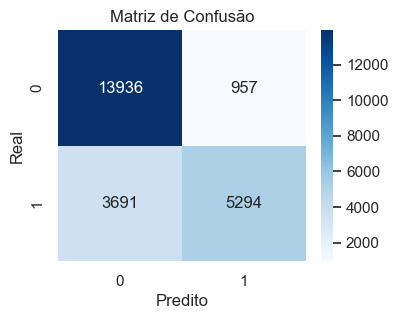

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_logistic_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Acurácia : {accuracy_score(y_test, y_pred):.03f}")
    print(f"Precisão : {precision_score(y_test, y_pred):.03f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.03f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.03f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

def train_and_test(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    pipe = Pipeline(pipeline + [('clf', LogisticRegression(max_iter=1000))])
    model = pipe.fit(X_train, y_train['is_canceled'])
    evaluate_logistic_regression_model(model, X_test, y_test)
    return model #, x_train, X_test, y_train, y_test

model = train_and_test(X_encoded, y, pipeline_items)

Modelo falhou em convergir. Vamos tentar normalizar os valores

Acurácia : 0.799
Precisão : 0.839
Recall   : 0.576
F1-score : 0.683


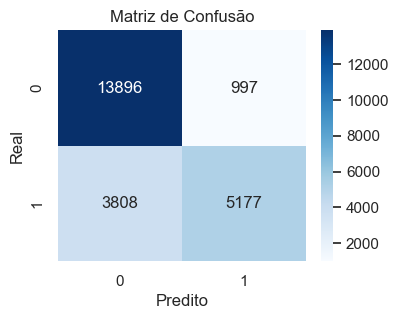

In [51]:
from sklearn.preprocessing import MinMaxScaler

model = train_and_test(X_encoded, y, pipeline_items + [('norm', MinMaxScaler())])

Essa performance parece baixa...

## Análise de _features_

In [52]:
coef = pd.DataFrame({
    "feature": X_encoded.columns,
    "coef": model['clf'].coef_[0]
})

coef["abs_coef"] = coef["coef"].abs()
coef_sorted = coef.sort_values("abs_coef", ascending=False)
coef_sorted.head(20)

,feature,coef,abs_coef
14,required_car_parking_spaces,-21.372,21.372
9,booking_changes,18.831,18.831
11,company,-6.894,6.894
10,agent,-6.805,6.805
26,deposit_type_Non Refund,4.446,4.446
1,arrival_date_day_of_month,3.967,3.967
6,babies,3.537,3.537
15,total_of_special_requests,-3.147,3.147
0,lead_time,3.143,3.143
2,stays_in_weekend_nights,2.869,2.869


O número de vagas de carro reservadas têm um peso enorme! Esse não conseguimos interpretar.

`booking_changes` é o segundo fator mais relevante, e faz sentido: uma reserva problemática antes de se tornar totalmente inviável.

`company`  e `agent` são interessantes, porque aparentemente reduzem a probabilidade de cancelamento. Talvez esses garantam que a viagem seja mais bem planejada?

Talvez a variável mais estranha seja o tipo de reserva sem reembolso. Afinal, se não pode haver reembolso, então os hóspedes podem ser relutantes em perder o dinheiro. Mas a variável parece aumentar a probabilidade de cancelamento! Mas isso parece advir de agentes solicitarem muitas reservas sem reembolso.

In [55]:
q2_df.groupby(['agent','deposit_type'])['is_canceled'].mean().unstack()

deposit_type,No Deposit,Non Refund,Refundable
agent,,,
1.000,0.387,1.000,NaN
2.000,0.210,NaN,NaN
3.000,0.208,1.000,NaN
4.000,0.590,1.000,NaN
5.000,0.255,1.000,NaN
...,...,...,...
510.000,0.000,NaN,NaN
526.000,0.100,NaN,NaN
527.000,0.000,NaN,NaN


## Justificativa de modelo

A regressão logística é mais apropriada porque permite uma resposta binária, enquanto a regressão linear leva a uma resposta numérica que varia muito. Como a saída a ser estimada é booleana (cancelado/não cancelado), a regressão logística é a escolha mais óbvia.